In [ ]:
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import subprocess
import os
from PIL import Image
import os
import xarray as xr
from matplotlib.pyplot import imshow, figure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ds = xr.open_mfdataset('/content/drive/MyDrive/data/df_2004_2021.nc')

In [ ]:
sdd = ds.loc[dict(Date=slice('2015-11-15', '2020-11-15'))]

In [ ]:
my_df = sdd['TMAX'].values

In [ ]:
my_df.shape

(1828, 50, 94)

# Simple LRMC

In [ ]:
def SVTC(mat, tau):
    u, s, v = np.linalg.svd(mat, full_matrices = False)
    idx = np.sum(s > tau)
    return u[:, : idx] @ np.diag(s[: idx] - tau) @ v[: idx, :]

def SiLRMC(mat, rho0, epsilon, maxiter):
    dim1, dim2 = mat.shape
    pos_missing = np.where(mat == 0)
    last_mat = mat.copy()
    snorm = np.linalg.norm(mat, 'fro')
    T = np.zeros((dim1, dim2))
    Z = mat.copy()
    Z[pos_missing] = np.mean(Z[Z != 0])
    it = 0
    rho = rho0
    while True:
        rho = min(rho * 1.05, 1e5)
        X = SVTC(Z - T / rho, 1 / rho)
        Z[pos_missing] = (X + T / rho)[pos_missing]
        T = T + rho * (X - Z)
        tol = np.linalg.norm((X - last_mat), 'fro') / snorm
        last_mat = X.copy()
        it += 1
        if it % 50 == 0:
            print('Iter: {}'.format(it))
            print('Norm Error: {:.6}'.format(tol))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break
    return X

## LRMCDMD

In [ ]:
def dmd(X1, X2, rank):
    """DMD."""
    u, s, v = np.linalg.svd(X1, full_matrices = 0)
    A_tilde = u[:, : rank].T @ X2 @ v[: rank, :].T @ np.linalg.inv(np.diag(s[: rank]))
    Lambda, D = np.linalg.eig(A_tilde)
    Phi = X1 @ v[: rank, :].T @ np.linalg.inv(np.diag(s[: rank])) @ D
    A = Phi @ np.diag(Lambda)
    pinv_Phi = np.linalg.pinv(Phi)
    temp = A @ (pinv_Phi @ X1)
    
    return temp.real, A, pinv_Phi

In [ ]:
def LRMCDMD(sparse_mat, rho, lambda0, epsilon, maxiter, rank = 50):
    """LRMCDMD"""
    
    dim1, dim2 = sparse_mat.shape
    Tf = np.zeros((dim1, dim2 - 1))
    Tb = np.zeros((dim1, dim2 - 1))
    X = sparse_mat[:, 1 :]
    indx = X != 0
    Z = sparse_mat[:, : dim2 - 1]
    indz = Z != 0
    it = 0
    last_mat = sparse_mat
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho=rho
    while True:
        rho = min(rho * 1.05, 1e5)
        temp, _, _ = dmd(Z, X, rank)
        X = SVTC(Tf / lambda0 + temp, 1 / lambda0)
        Tf = Tf + rho * (sparse_mat[:, 1 :] - X) * indx
        temp, _, _ = dmd(X, Z, rank)
        Z = SVTC(Tb / lambda0 + temp, 1 / lambda0)
        Tb = Tb + rho * (sparse_mat[:, : dim2 - 1] - Z) * indz
        mat_hat = 0.5 * (np.append(Z, X[:, -1].reshape([dim1, 1]), axis = 1)
                         + np.append(Z[:, 0].reshape([dim1, 1]), X, axis = 1))
        X[np.where(1 - indx)] = (mat_hat[:, 1 :])[np.where(1 - indx)]
        Z[np.where(1 - indz)] = (mat_hat[:, : dim2 - 1])[np.where(1 - indz)]
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 50 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
        if (tol < epsilon) or (it >= maxiter):
            break
    return mat_hat


In [ ]:
from numpy.linalg import inv as inv

In [ ]:
def scale_to_data(vec, alpha):
    dim = vec.shape[0]
    new_vec = np.zeros(dim)
    for i in range(dim):
        new_vec[i] = vec[i] * np.exp((i + 1) * alpha / 2)
    return new_vec

def scale_back_data(vec, alpha):
    dim = vec.shape[0]
    new_vec = np.zeros(dim)
    for i in range(dim):
        new_vec[i] = vec[i] * np.exp(- (i + 1) * alpha / 2)
    return new_vec

In [ ]:
def hankel(vec, window_length):
    column_num = vec.shape[0] - window_length + 1
    hankel_mat = np.zeros((window_length, column_num))
    for i in range(window_length):
        hankel_mat[i, :] = vec[i : column_num + i]
    return hankel_mat

def hankel2vec(mat):
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim1, dim1 + dim2 - 1))
    for i in range(dim1):
        new_mat[i, i : dim2 + i] = mat[i, :]
    return np.true_divide(new_mat.sum(0), (new_mat != 0).sum(0))

In [ ]:
uni_X = my_df[:,1,1].reshape(-1,1)
uni_X.shape

(1828, 1)

In [ ]:
h_scaler = MinMaxScaler()
h_scaler = h_scaler.fit(uni_X)
uni_X_sc = h_scaler.transform(uni_X)
uni_X_sctr = uni_X_sc[:-300].copy()
vt =  uni_X_sc.reshape(-1,)

In [ ]:
vect = uni_X_sctr.reshape(-1,)
h= 300;
hank_X = hankel(np.append(vect, np.zeros(h)), window_length=1095).T

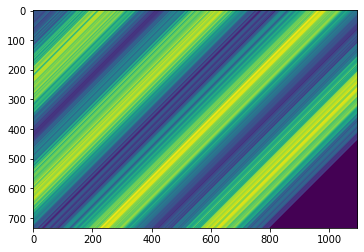

In [ ]:
plt.imshow(hank_X)

In [ ]:
uni_X_sctr.shape

(1528, 1)

In [ ]:
hcX = hank_X.copy()
ind = hcX!=0
ind

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
Omega =  np.random.choice([0, 1], size=hank_X.shape, p=((1 - 0.5), 0.5)).astype(bool)

In [ ]:
Omega

array([[ True,  True, False, ..., False,  True,  True],
       [ True,  True, False, ..., False,  True,  True],
       [ True,  True, False, ..., False, False,  True],
       ...,
       [ True,  True,  True, ..., False, False,  True],
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
OmegaF = np.logical_and(Omega, ind) 

In [ ]:
OmegaF


array([[ True,  True, False, ..., False,  True,  True],
       [ True,  True, False, ..., False,  True,  True],
       [ True,  True, False, ..., False, False,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
hank_X_sp = hank_X.copy()
hank_X_sp[np.where(1-OmegaF)]= 0

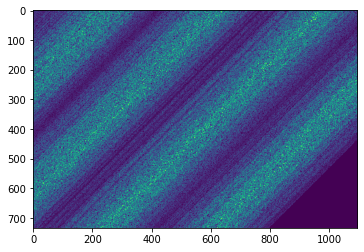

In [ ]:
plt.imshow(hank_X_sp)

In [ ]:
hank_X_sp

array([[0.34479347, 0.35171902, 0.        , ..., 0.        , 0.33663121,
        0.37076428],
       [0.35171902, 0.3480089 , 0.        , ..., 0.        , 0.37076428,
        0.43433094],
       [0.3480089 , 0.35246104, 0.        , ..., 0.        , 0.        ,
        0.45164482],
       ...,
       [0.23151125, 0.27603265, 0.28444225, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28444225, 0.27405392, 0.25302993, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
rho1 = 1e-1
epsilon = 1e-5
maxiter = 100
lambda0 = 10 * rho1
sparse_mat=hank_X_sp.copy()
xout2 = SiLRMC(sparse_mat, rho1, epsilon, maxiter)

Iter: 50
Norm Error: 1.71562e-05



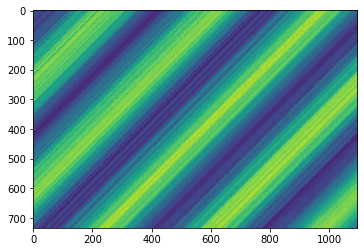

In [ ]:
plt.imshow(xout2)

In [ ]:
xout1  = LRMCDMD(sparse_mat, rho1, lambda0, epsilon, maxiter=50, rank = 50)

Iter: 50
Tolerance: 0.0770116


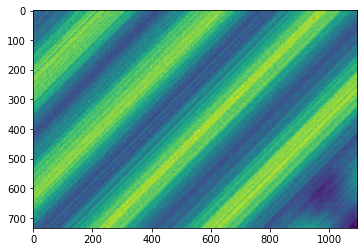

In [ ]:
plt.imshow(xout1)

In [ ]:
vout1 = hankel2vec(xout1)
vout2 = hankel2vec(xout2)
vtr = h_scaler.inverse_transform(vt.reshape(uni_X.shape[0], uni_X.shape[1])).reshape(-1,)
vout1= h_scaler.inverse_transform(vout1.reshape(-1,1))
vout2= h_scaler.inverse_transform(vout2.reshape(-1,1))

In [ ]:
vtr.shape, vout1.shape, vout2.shape

((1828,), (1828, 1), (1828, 1))

In [ ]:
Om=hankel2vec(OmegaF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [ ]:
Om[np.where(Om==np.nan)]=0


In [ ]:
vtr2= vtr*Om;

In [ ]:
# np.isnan(vtr2).sum()


In [ ]:
import seaborn as sns
sns.set(style='dark')

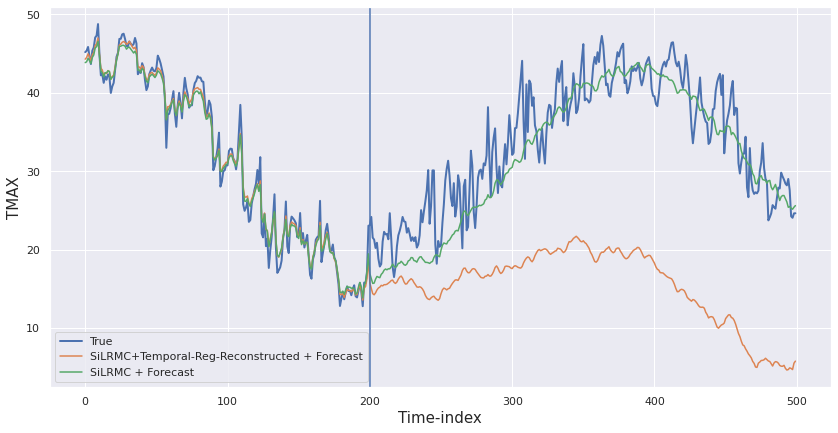

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(vtr[-500:], label='True', linewidth=2)
plt.plot(vout1[-500:], label='SiLRMC+Temporal-Reg-Reconstructed + Forecast')
plt.plot(vout2[-500:], label='SiLRMC + Forecast')
plt.axvline(x=200)
plt.xlabel('Time-index', fontdict={'fontsize': 15})
plt.ylabel('TMAX', fontdict={'fontsize': 15})
plt.grid(1)
plt.legend(loc='best')
# plt.title('Comparision between actual, SiLRMC+Temporal-Reg-Forecast, SiLRMC-Forecast', fontdict={'fontsize': 18})
plt.savefig("/content/Hankel_forecast_SR300.0.5.png", format="png")


In [ ]:
sns.reset_orig()

In [ ]:
dim1, dim2 = sparse_mat.shape
dim2

1095

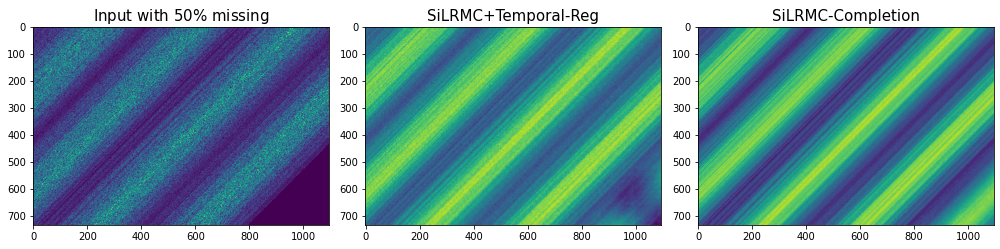

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(hank_X_sp)
plt.title("Input with $50\%$ missing", fontdict={'fontsize': 15}) 

plt.subplot(1,3,2)
plt.imshow(xout1)
plt.title("SiLRMC+Temporal-Reg", fontdict={'fontsize': 15}) 

plt.subplot(1,3,3)
plt.imshow(xout2)
plt.title("SiLRMC-Completion", fontdict={'fontsize': 15}) 

plt.subplots_adjust(wspace=0.025, hspace=0.05, left=0.05, right=0.95, bottom=0.05, top=0.95)  
plt.tight_layout()
plt.savefig("/content/Hankel_Impute_SR300.0.5.png", format="png")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 

def smape_(act,forc):
    return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))



In [ ]:
SMAPE = smape_(vtr[-500:], vout1[-500:])
MAE = mean_absolute_error(vtr[-500:],vout1[-500:])
RMSE = np.sqrt(mean_squared_error(vtr[-500:],vout1[-500:]))  
RMSE, MAE, SMAPE

(15.383326512986763, 11.364899352288433, 29128.041367427842)

In [ ]:
SMAPE = smape_(vtr[-500:], vout2[-500:])
MAE = mean_absolute_error(vtr[-500:],vout2[-500:])
RMSE = np.sqrt(mean_squared_error(vtr[-500:],vout2[-500:]))  
RMSE, MAE, SMAPE

(3.1734103745655444, 2.280036489757249, 17813.636359199674)